In [1]:
# -*- coding: utf-8 -*-
# 必要ライブラリ
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import japanize_matplotlib
from statistics import mean, median,variance,stdev

/usr/local/lib/python3.7/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


# 移動平均によるバースト

In [2]:
def estimate_season(counts, total_avg):
    continuous_days = 0
    for index, oneday in counts.iterrows():
        # counts.iterrows()はビューではなくコピーを返すので、直接加えても元のcountsには追加されない。
        
        if oneday['7日移動平均'] >= oneday['30日移動平均']:
            continuous_days += 1
            if oneday['前日の関連ツイート数'] >= total_avg \
                and continuous_days >= 3.5:
                    counts.at[index, '見頃判断'] = 1 
            else:
                counts.at[index, '見頃判断'] = 0
        else:
            continuous_days = 0
            counts.at[index, '見頃判断'] = 0

# main

In [3]:
START_DATE = dt.date(2015, 10, 1) # plotする期間
END_DATE = dt.date(2015, 12,31)

In [4]:
"""prefectures = ["tk", "hk", "is"]
targets = ["icho", "kaede", "others", "koyo"]"""

file = "./out/daily_count_"

target = "is_koyo"

"""
tk_icho
tk_kaede
tk_others
tk_koyo
hk_icho
hk_kaede
hk_others
hk_koyo
is_icho
is_kaede
is_others
is_koyo
"""

counts = pd.read_table(file + target + ".tsv", names=('月', '日', '関連ツイート数'), header=None)

In [5]:
# '月'カラムと'日'カラムで別れているので、まとめてdate型の一つのdatetime型カラムにする。
counts['年月日'] = pd.to_datetime('2015-'+ counts['月'].astype(str) + '-'+ counts['日'].astype(str))
counts = counts.drop(columns=['月', '日'])
counts = counts.set_index('年月日')


In [6]:
# 本来なら1年移動平均だが、データ期間全体(2/17~12/31)の平均を使っている。(遠藤論文と同じ)
total_avg = counts['関連ツイート数'].mean()

counts['前日の関連ツイート数']  = counts['関連ツイート数'].shift()
counts['7日移動平均'] = counts['関連ツイート数'].rolling(7, min_periods=1).mean().shift()
counts['30日移動平均'] = counts['関連ツイート数'].rolling(30, min_periods=1).mean().shift()

# ただの移動平均だと、その日にちの関連ツイート数まで平均に含まれている。
# 遠藤手法では、1日前~n日前の移動平均を用いる。なので、shift()で一行ずらしている。

In [7]:
estimate_season(counts, total_avg)
# print(counts.query('見頃判断 == 1'))

## plot

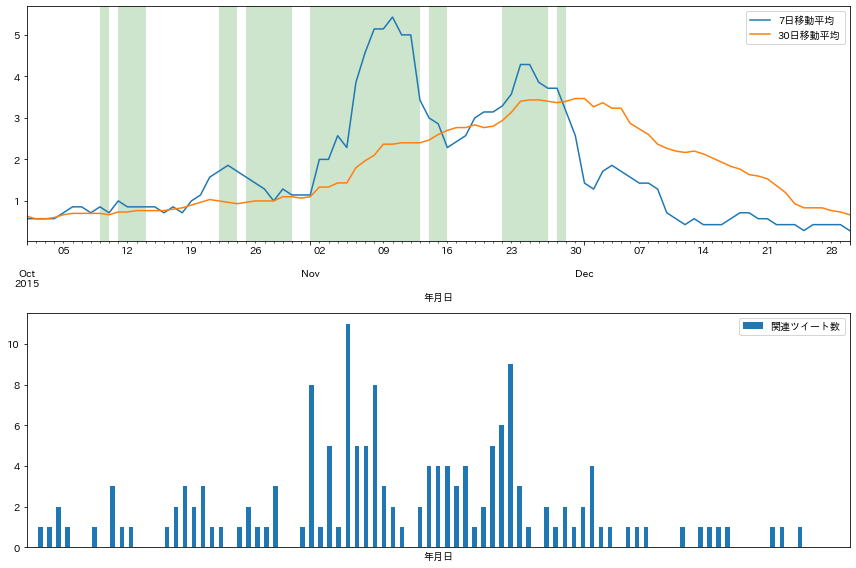

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

counts[START_DATE : END_DATE].plot(y="7日移動平均", ax=ax1)
counts[START_DATE : END_DATE].plot(y="30日移動平均", ax=ax1)
counts[START_DATE : END_DATE].plot.bar(y="関連ツイート数", ax=ax2, xticks=[]) 

for season_day in counts[START_DATE : END_DATE].query('見頃判断 == 1').index:
    td_1d = dt.timedelta(days=1)
    ax1.axvspan(season_day.date(), season_day.date() + td_1d,
           facecolor='g', edgecolor='none', alpha=.2)
    
fig.tight_layout()

path = "./png/"
plt.savefig(path + target + ".png")

In [9]:
prefectures = ["tk", "hk", "is"]
targets = ["icho", "kaede", "others", "koyo"]

for pre in prefectures:
    for tar in targets:
        print(pre+"_"+tar)

tk_icho
tk_kaede
tk_others
tk_koyo
hk_icho
hk_kaede
hk_others
hk_koyo
is_icho
is_kaede
is_others
is_koyo
